In [238]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:

from evaluation.questionnaire.questionnaire_plotter import QuestionnairePlotter
from evaluation.common import InputCombination



translation = {
    "Car" : "Car",
    "Auto" : "Car",
    "TUI" : "TUI",
    "Tangible" : "TUI",
    "Geste" : "Gesture",
    "Gesture" : "Gesture"
}
            
plotter = QuestionnairePlotter()
# plotter.plot_rankings(RankCategory.MostAccurate)
# plotter.summary()
# plotter.print_orders()



Mean: 34.2
Standard Deviation: 5.621387729022079


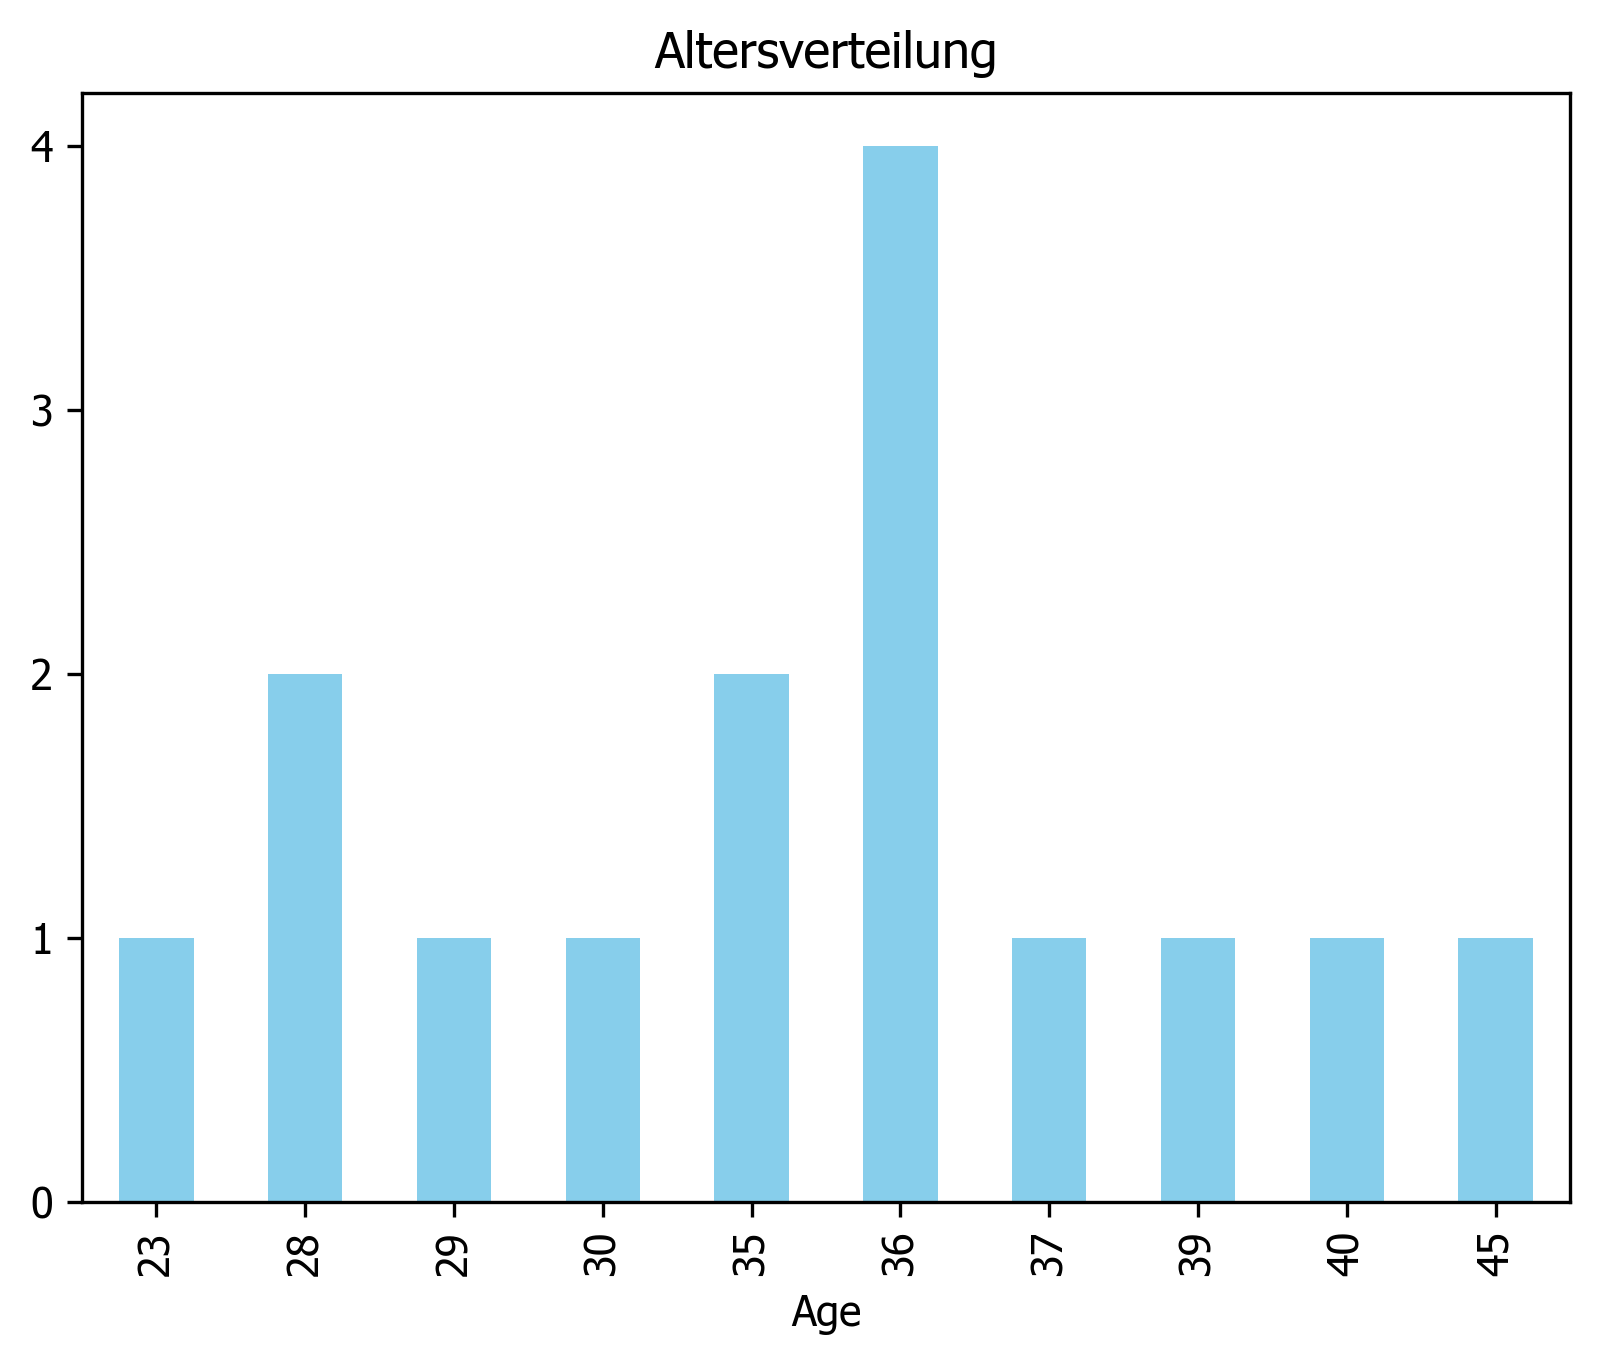

In [240]:
plotter.plot_age()

In [241]:
plotter.plot_usage_frequency()

0                                       {'Smartphone': 'täglich', 'Tablet': 'regelmäßig', 'Multitouch-Tisch': 'regelmäßig', 'Tangibles': 'regelmäßig', 'Videospiele': 'regelmäßig'}
1                      {'Smartphone': 'täglich', 'Tablet': 'täglich', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'schon einmal genutzt', 'Videospiele': 'regelmäßig'}
2                     {'Smartphone': 'täglich', 'Tablet': 'regelmäßig', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}
3                     {'Smartphone': 'täglich', 'Tablet': 'regelmäßig', 'Multitouch-Tisch': 'schon einmal genutzt', 'Tangibles': 'noch nie', 'Videospiele': 'schon einmal genutzt'}
4                               {'Smartphone': 'täglich', 'Tablet': 'hin und wieder', 'Multitouch-Tisch': 'regelmäßig', 'Tangibles': 'regelmäßig', 'Videospiele': 'hin und wieder'}
5                                 {'Smartphone': 'täglich', 'Tablet': 'regelmäßig', 'Multitouch-Tisc

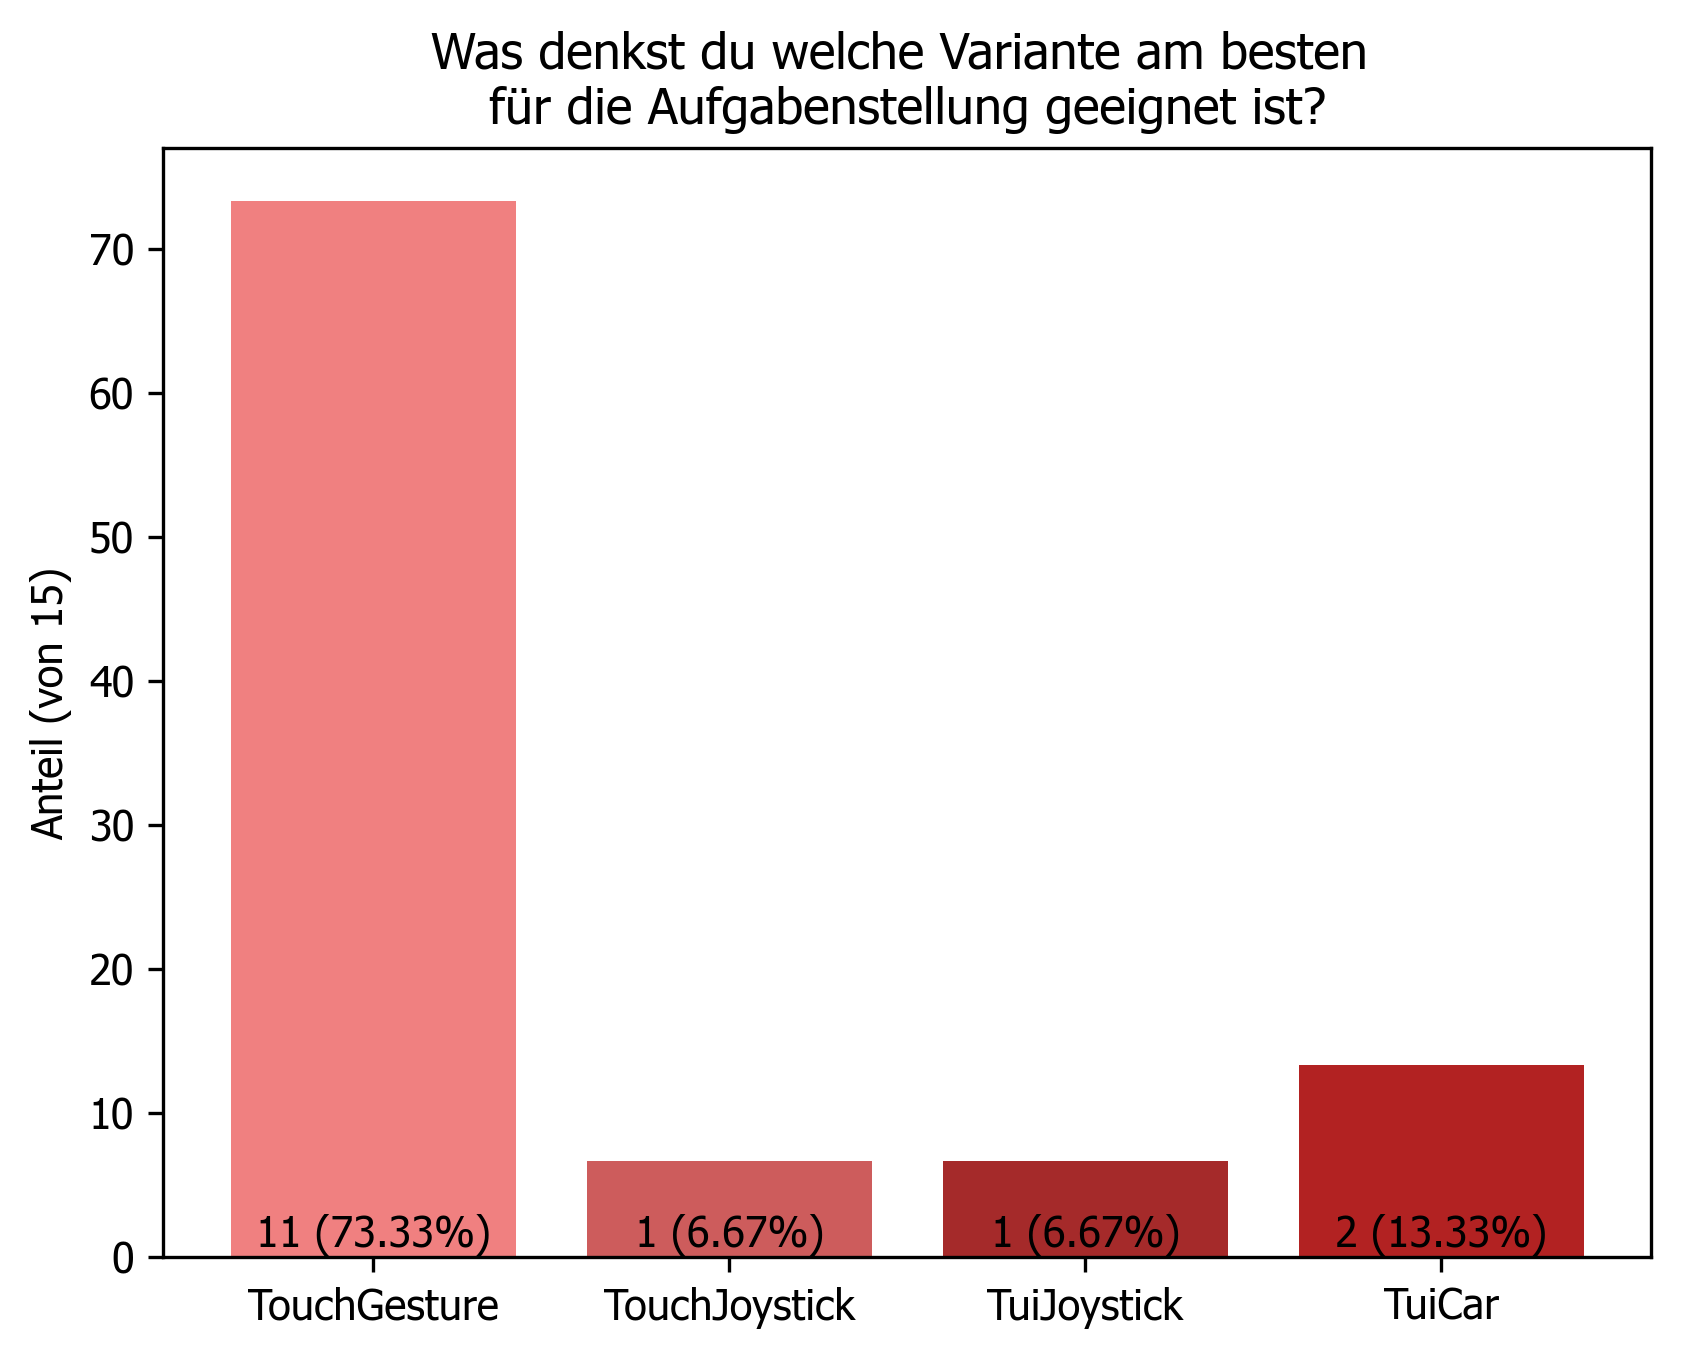

In [242]:
plotter.plot_first_impression(normalized=True)

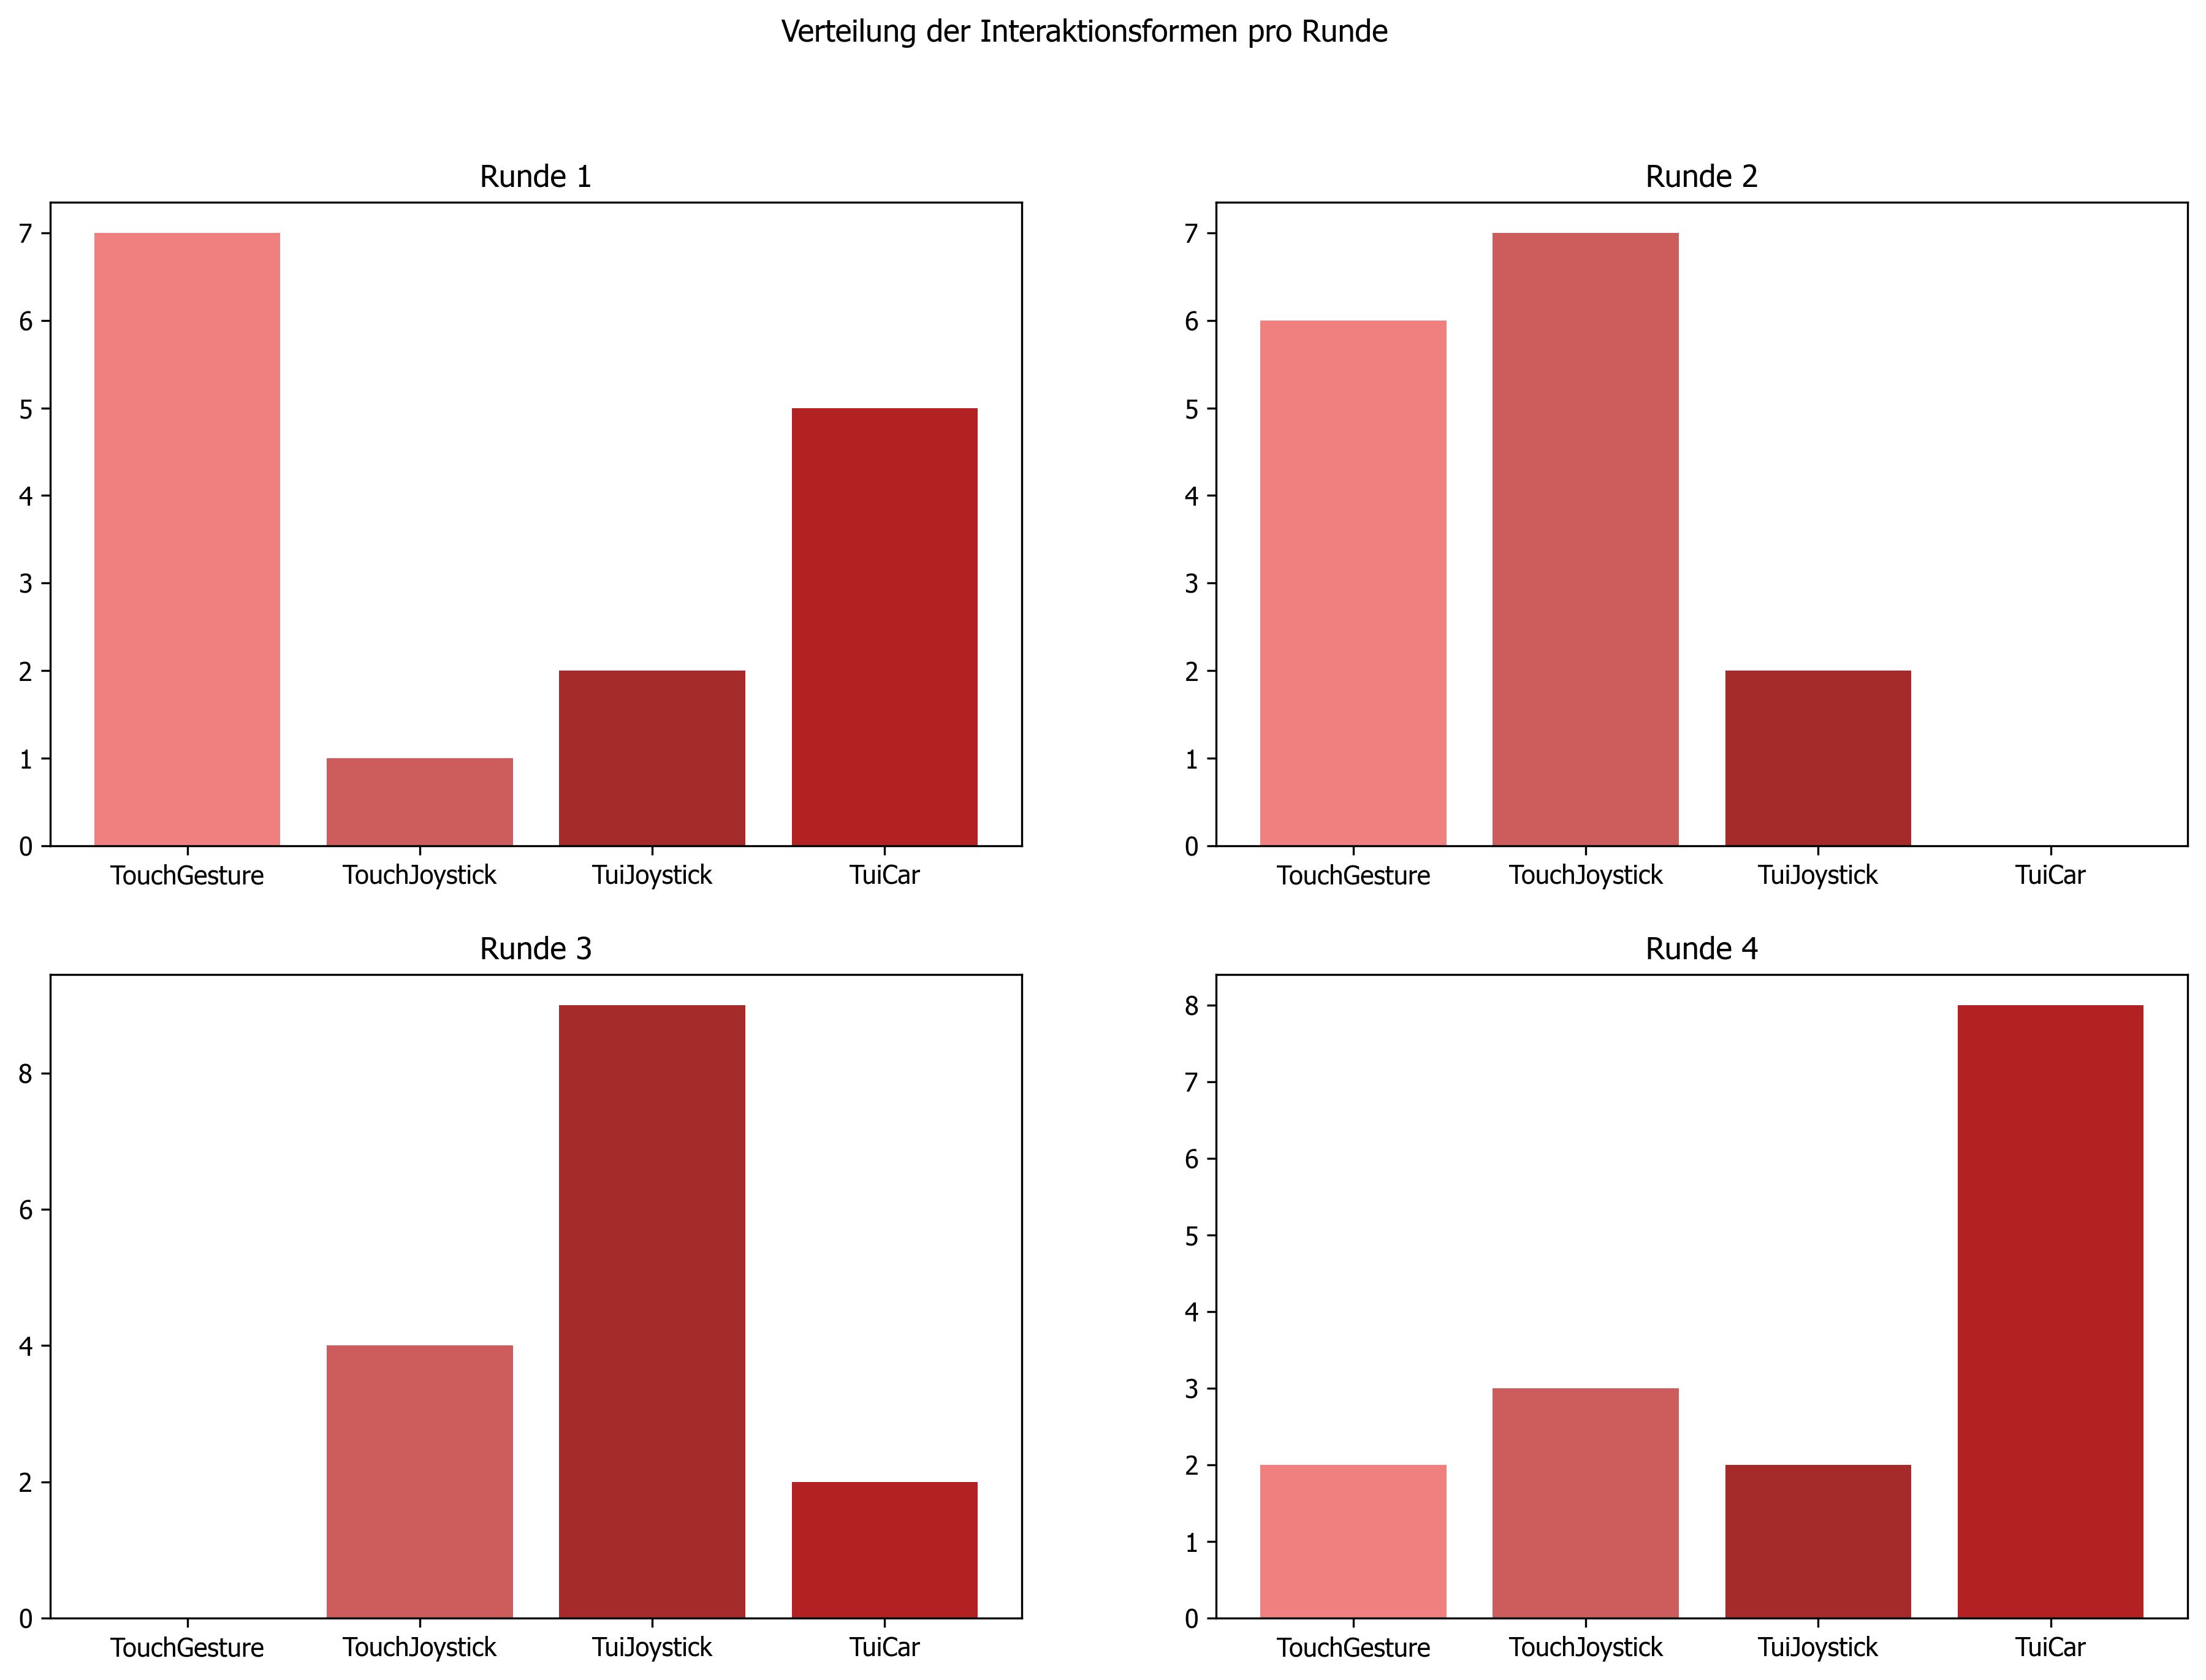

In [243]:
plotter.plot_sequence()

Standard Deviation:
Attraktivität        1.060099
Effizienz            1.060099
Steuerbarkeit        0.639940
Originalität         0.990430
Stimulation          1.060099
Nützlichkeit         0.961150
Durchschaubarkeit    0.712140
dtype: float64


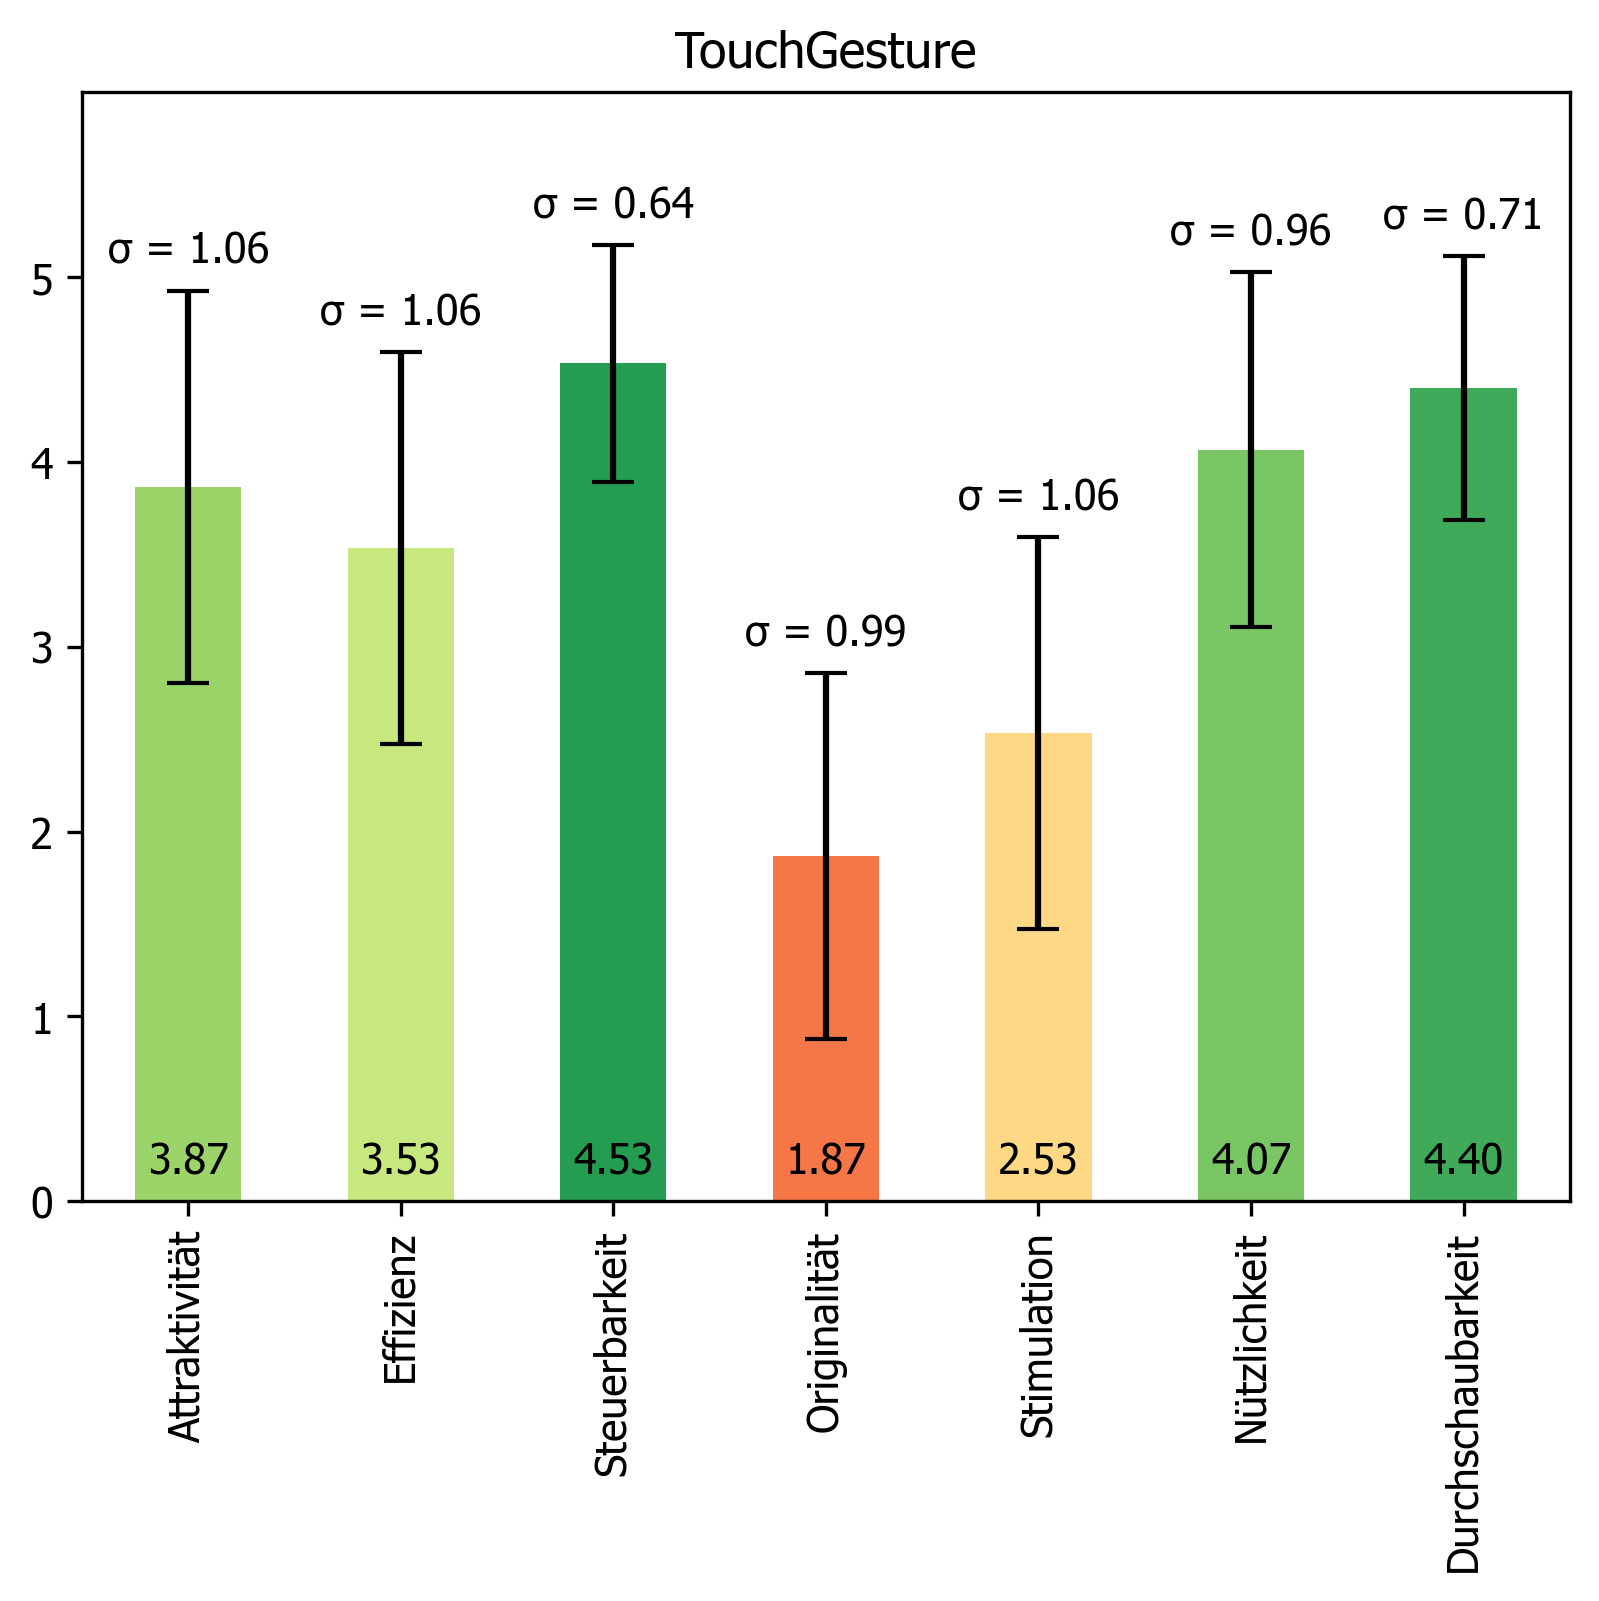

,Attraktivität,Effizienz,Steuerbarkeit,Originalität,Stimulation,Nützlichkeit,Durchschaubarkeit
UserId,,,,,,,
1,"((5, angenehm),)","((2, eher ineffizient),)","((5, vorhersagbar),)","((2, eher herkömmlich),)","((2, eher langweilig),)","((2, eher nutzlos),)","((4, eher einfach), (5, einleuchtend))"
2,"((4, eher angenehm),)","((3, neutral),)","((4, eher vorhersagbar),)","((3, neutral),)","((4, eher spannend),)","((4, eher nützlich),)","((4, eher einfach), (5, einleuchtend))"
3,"((2, eher unangenehm),)","((2, eher ineffizient),)","((3, neutral),)","((1, herkömmlich),)","((2, eher langweilig),)","((4, eher nützlich),)","((3, neutral), (5, einleuchtend))"
4,"((4, eher angenehm),)","((4, eher effizient),)","((5, vorhersagbar),)","((3, neutral),)","((3, neutral),)","((4, eher nützlich),)","((4, eher einfach), (3, neutral))"
5,"((3, neutral),)","((3, neutral),)","((5, vorhersagbar),)","((1, herkömmlich),)","((2, eher langweilig),)","((5, nützlich),)","((5, einfach), (5, einleuchtend))"
6,"((5, angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((2, eher herkömmlich),)","((3, neutral),)","((5, nützlich),)","((5, einfach), (5, einleuchtend))"
7,"((5, angenehm),)","((5, effizient),)","((5, vorhersagbar),)","((1, herkömmlich),)","((2, eher langweilig),)","((5, nützlich),)","((5, einfach), (5, einleuchtend))"
8,"((4, eher angenehm),)","((5, effizient),)","((4, eher vorhersagbar),)","((2, eher herkömmlich),)","((4, eher spannend),)","((4, eher nützlich),)","((4, eher einfach), (5, einleuchtend))"
9,"((3, neutral),)","((3, neutral),)","((4, eher vorhersagbar),)","((1, herkömmlich),)","((2, eher langweilig),)","((3, neutral),)","((2, eher kompliziert), (3, neutral))"


In [244]:
plotter.plot_usability(InputCombination.TouchGesture)

Standard Deviation:
Attraktivität        1.245946
Effizienz            0.975900
Steuerbarkeit        1.183216
Originalität         0.899735
Stimulation          0.816497
Nützlichkeit         0.828079
Durchschaubarkeit    0.994030
dtype: float64


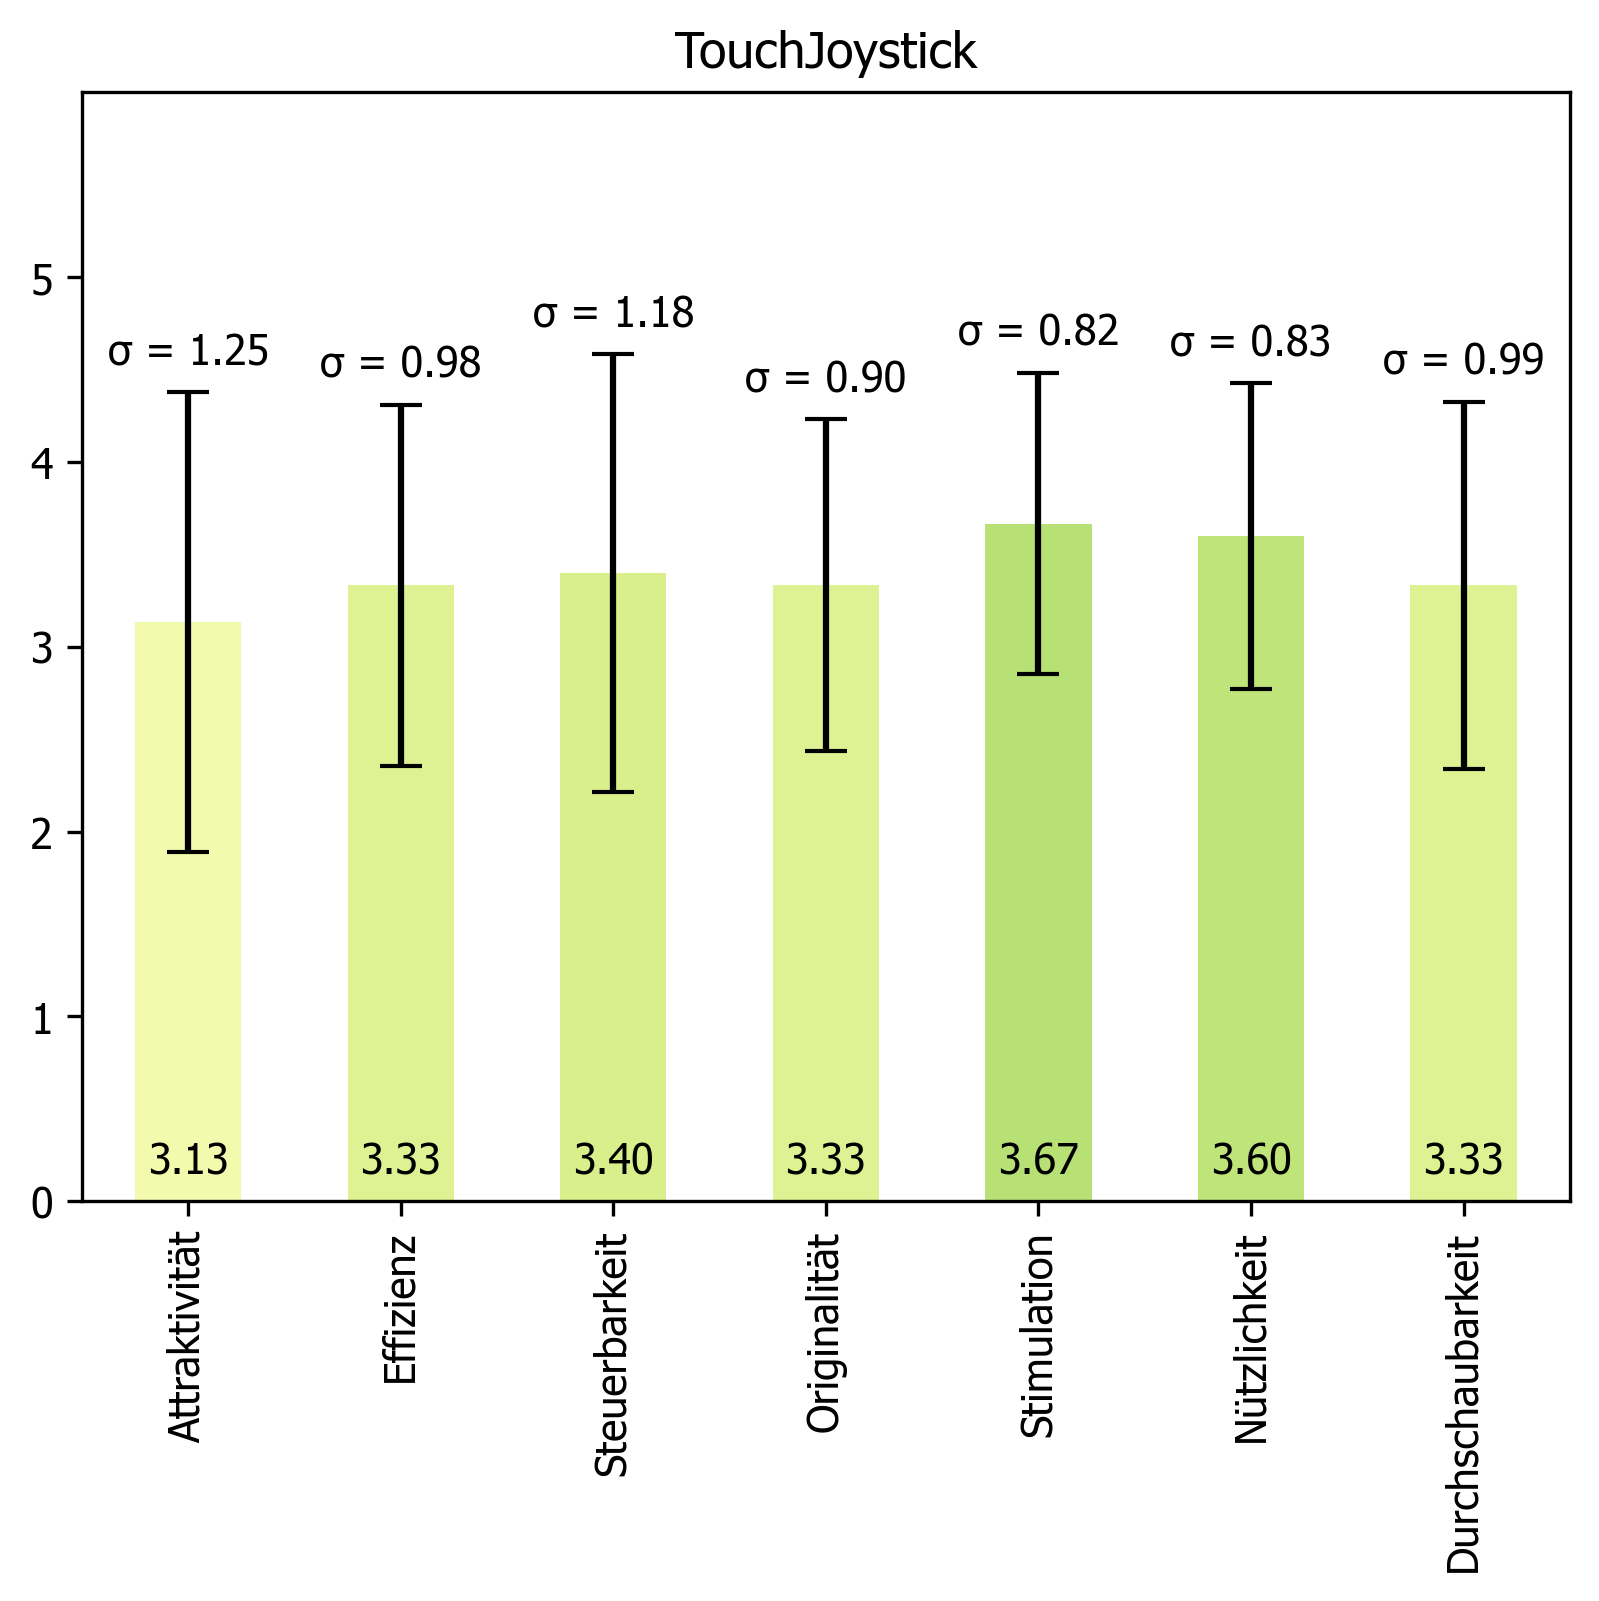

,Attraktivität,Effizienz,Steuerbarkeit,Originalität,Stimulation,Nützlichkeit,Durchschaubarkeit
UserId,,,,,,,
1,"((3, neutral),)","((3, neutral),)","((2, eher unberechenbar),)","((4, eher neuartig),)","((4, eher spannend),)","((3, neutral),)","((2, eher kompliziert), (3, neutral))"
2,"((5, angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((4, eher neuartig),)","((4, eher spannend),)","((5, nützlich),)","((5, einfach), (5, einleuchtend))"
3,"((1, unangenehm),)","((2, eher ineffizient),)","((1, unberechenbar),)","((3, neutral),)","((4, eher spannend),)","((3, neutral),)","((1, kompliziert), (3, neutral))"
4,"((4, eher angenehm),)","((3, neutral),)","((3, neutral),)","((2, eher herkömmlich),)","((3, neutral),)","((4, eher nützlich),)","((4, eher einfach), (4, eher einleuchtend))"
5,"((5, angenehm),)","((5, effizient),)","((5, vorhersagbar),)","((4, eher neuartig),)","((5, spannend),)","((5, nützlich),)","((4, eher einfach), (4, eher einleuchtend))"
6,"((2, eher unangenehm),)","((3, neutral),)","((3, neutral),)","((4, eher neuartig),)","((4, eher spannend),)","((3, neutral),)","((2, eher kompliziert), (3, neutral))"
7,"((2, eher unangenehm),)","((2, eher ineffizient),)","((4, eher vorhersagbar),)","((2, eher herkömmlich),)","((4, eher spannend),)","((3, neutral),)","((1, kompliziert), (3, neutral))"
8,"((3, neutral),)","((4, eher effizient),)","((2, eher unberechenbar),)","((3, neutral),)","((4, eher spannend),)","((4, eher nützlich),)","((2, eher kompliziert), (3, neutral))"
9,"((4, eher angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((4, eher neuartig),)","((3, neutral),)","((4, eher nützlich),)","((4, eher einfach), (4, eher einleuchtend))"


In [245]:
plotter.plot_usability(InputCombination.TouchJoystick)

Standard Deviation:
Attraktivität        1.082326
Effizienz            1.187234
Steuerbarkeit        1.146423
Originalität         0.798809
Stimulation          0.816497
Nützlichkeit         1.099784
Durchschaubarkeit    1.048809
dtype: float64


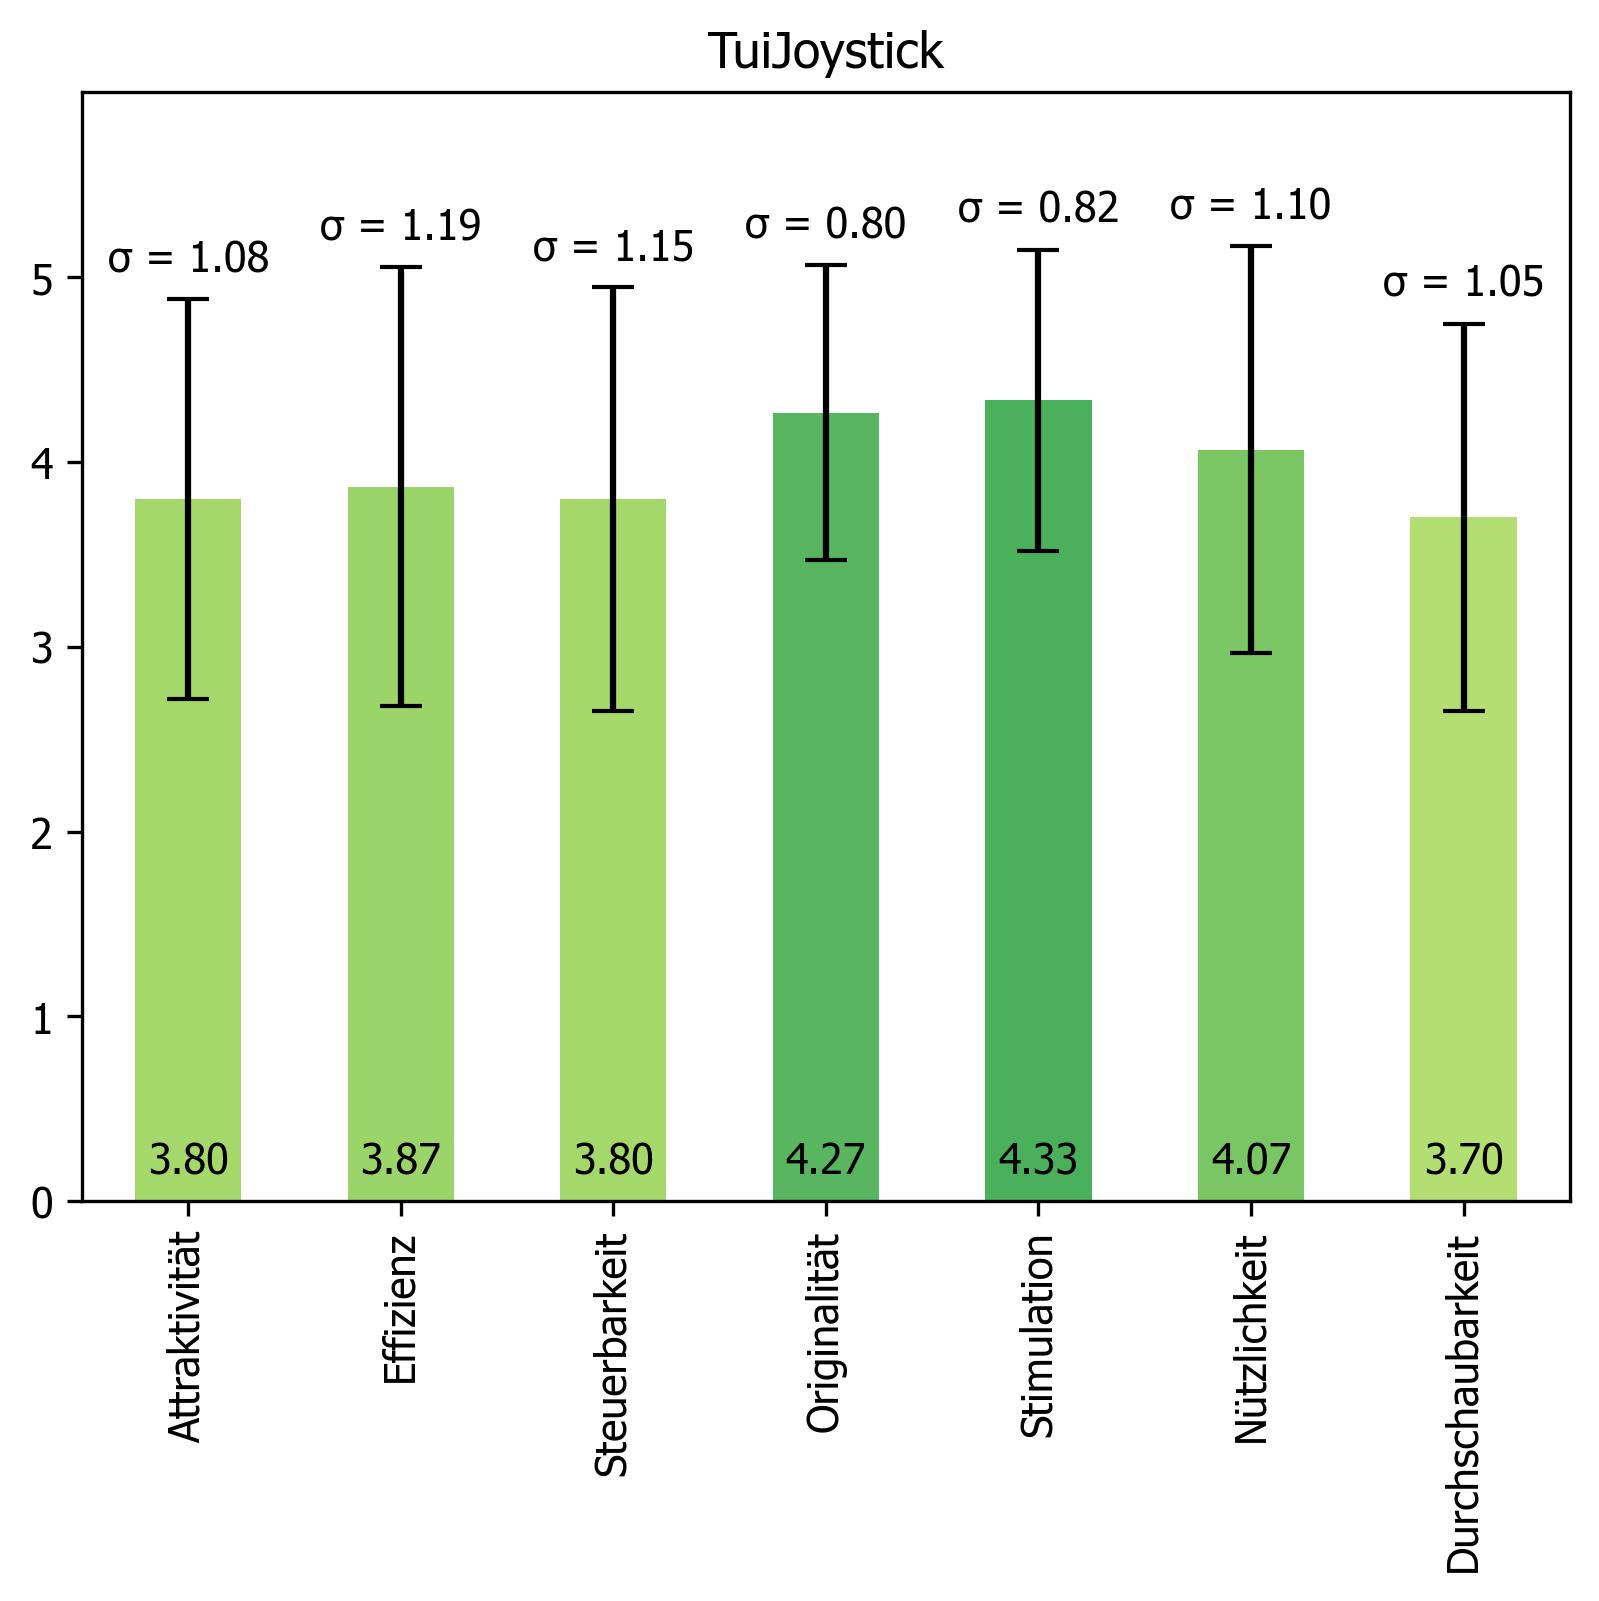

,Attraktivität,Effizienz,Steuerbarkeit,Originalität,Stimulation,Nützlichkeit,Durchschaubarkeit
UserId,,,,,,,
1,"((4, eher angenehm),)","((4, eher effizient),)","((5, vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((4, eher nützlich),)","((2, eher kompliziert), (4, eher einleuchtend))"
2,"((5, angenehm),)","((5, effizient),)","((5, vorhersagbar),)","((5, neuartig),)","((4, eher spannend),)","((4, eher nützlich),)","((4, eher einfach), (5, einleuchtend))"
3,"((3, neutral),)","((2, eher ineffizient),)","((2, eher unberechenbar),)","((5, neuartig),)","((4, eher spannend),)","((4, eher nützlich),)","((3, neutral), (4, eher einleuchtend))"
4,"((2, eher unangenehm),)","((2, eher ineffizient),)","((2, eher unberechenbar),)","((3, neutral),)","((3, neutral),)","((3, neutral),)","((2, eher kompliziert), (1, nicht einleuchtend))"
5,"((4, eher angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((4, eher neuartig),)","((5, spannend),)","((5, nützlich),)","((5, einfach), (4, eher einleuchtend))"
6,"((5, angenehm),)","((5, effizient),)","((5, vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((5, nützlich),)","((4, eher einfach), (4, eher einleuchtend))"
7,"((3, neutral),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((4, eher nützlich),)","((3, neutral), (4, eher einleuchtend))"
8,"((4, eher angenehm),)","((5, effizient),)","((4, eher vorhersagbar),)","((4, eher neuartig),)","((5, spannend),)","((4, eher nützlich),)","((4, eher einfach), (4, eher einleuchtend))"
9,"((4, eher angenehm),)","((3, neutral),)","((3, neutral),)","((4, eher neuartig),)","((3, neutral),)","((4, eher nützlich),)","((2, eher kompliziert), (4, eher einleuchtend))"


In [246]:
plotter.plot_usability(InputCombination.TuiJoystick)


Standard Deviation:
Attraktivität        0.899735
Effizienz            1.032796
Steuerbarkeit        0.639940
Originalität         0.816497
Stimulation          0.487950
Nützlichkeit         0.632456
Durchschaubarkeit    0.819407
dtype: float64


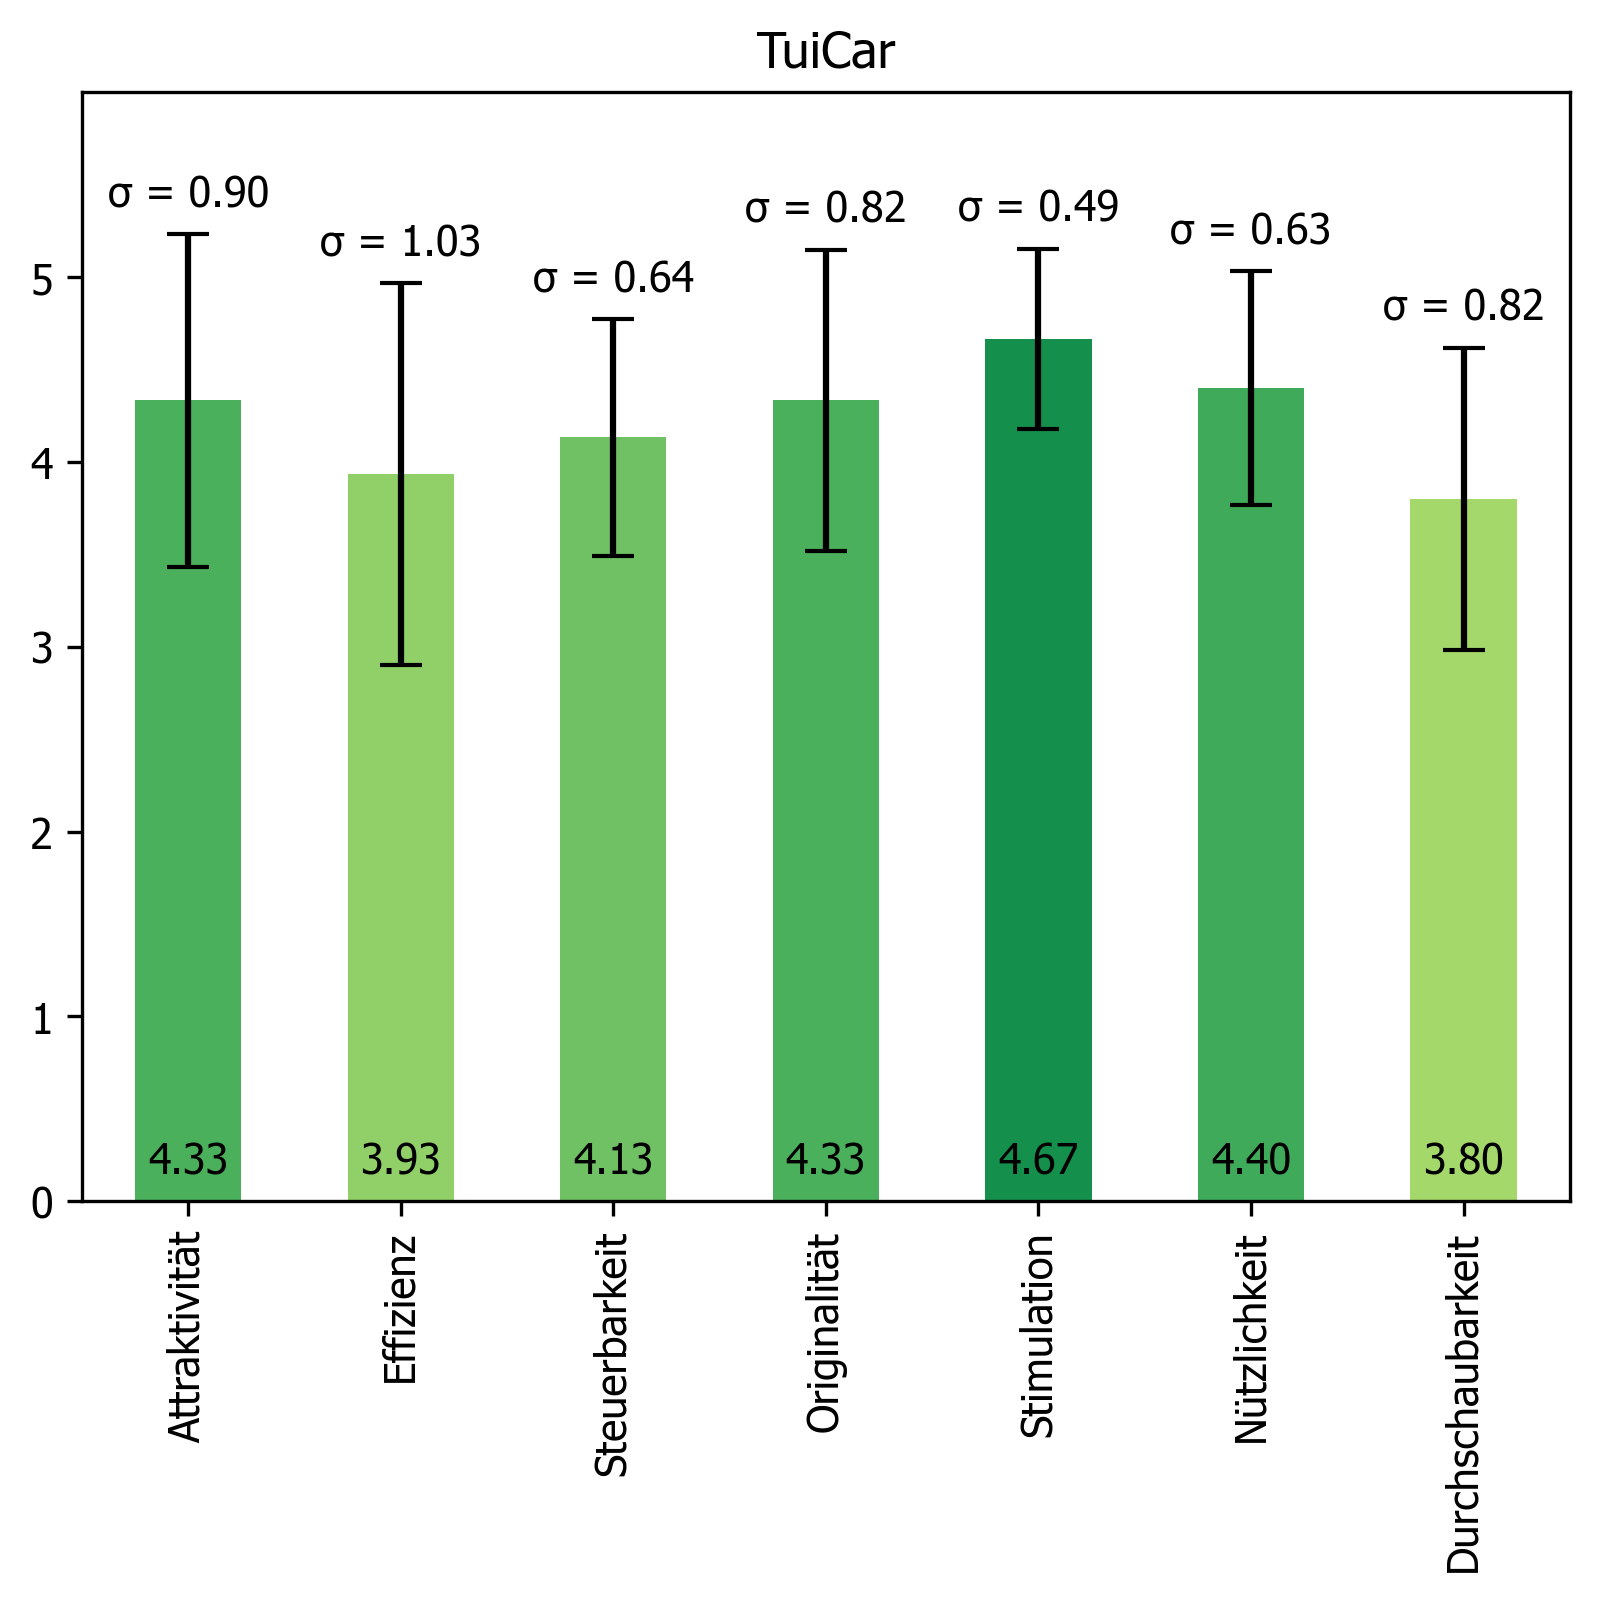

,Attraktivität,Effizienz,Steuerbarkeit,Originalität,Stimulation,Nützlichkeit,Durchschaubarkeit
UserId,,,,,,,
1,"((5, angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((4, eher nützlich),)","((4, eher einfach), (5, einleuchtend))"
2,"((5, angenehm),)","((5, effizient),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((5, nützlich),)","((4, eher einfach), (5, einleuchtend))"
3,"((5, angenehm),)","((4, eher effizient),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((4, eher nützlich),)","((4, eher einfach), (3, neutral))"
4,"((4, eher angenehm),)","((4, eher effizient),)","((5, vorhersagbar),)","((4, eher neuartig),)","((5, spannend),)","((5, nützlich),)","((4, eher einfach), (4, eher einleuchtend))"
5,"((5, angenehm),)","((3, neutral),)","((5, vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((5, nützlich),)","((2, eher kompliziert), (3, neutral))"
6,"((4, eher angenehm),)","((5, effizient),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((4, eher nützlich),)","((3, neutral), (4, eher einleuchtend))"
7,"((5, angenehm),)","((3, neutral),)","((4, eher vorhersagbar),)","((5, neuartig),)","((5, spannend),)","((5, nützlich),)","((3, neutral), (4, eher einleuchtend))"
8,"((2, eher unangenehm),)","((1, ineffizient),)","((3, neutral),)","((3, neutral),)","((4, eher spannend),)","((3, neutral),)","((2, eher kompliziert), (3, neutral))"
9,"((4, eher angenehm),)","((4, eher effizient),)","((5, vorhersagbar),)","((4, eher neuartig),)","((4, eher spannend),)","((5, nützlich),)","((4, eher einfach), (5, einleuchtend))"


In [247]:
plotter.plot_usability(InputCombination.TuiCar)

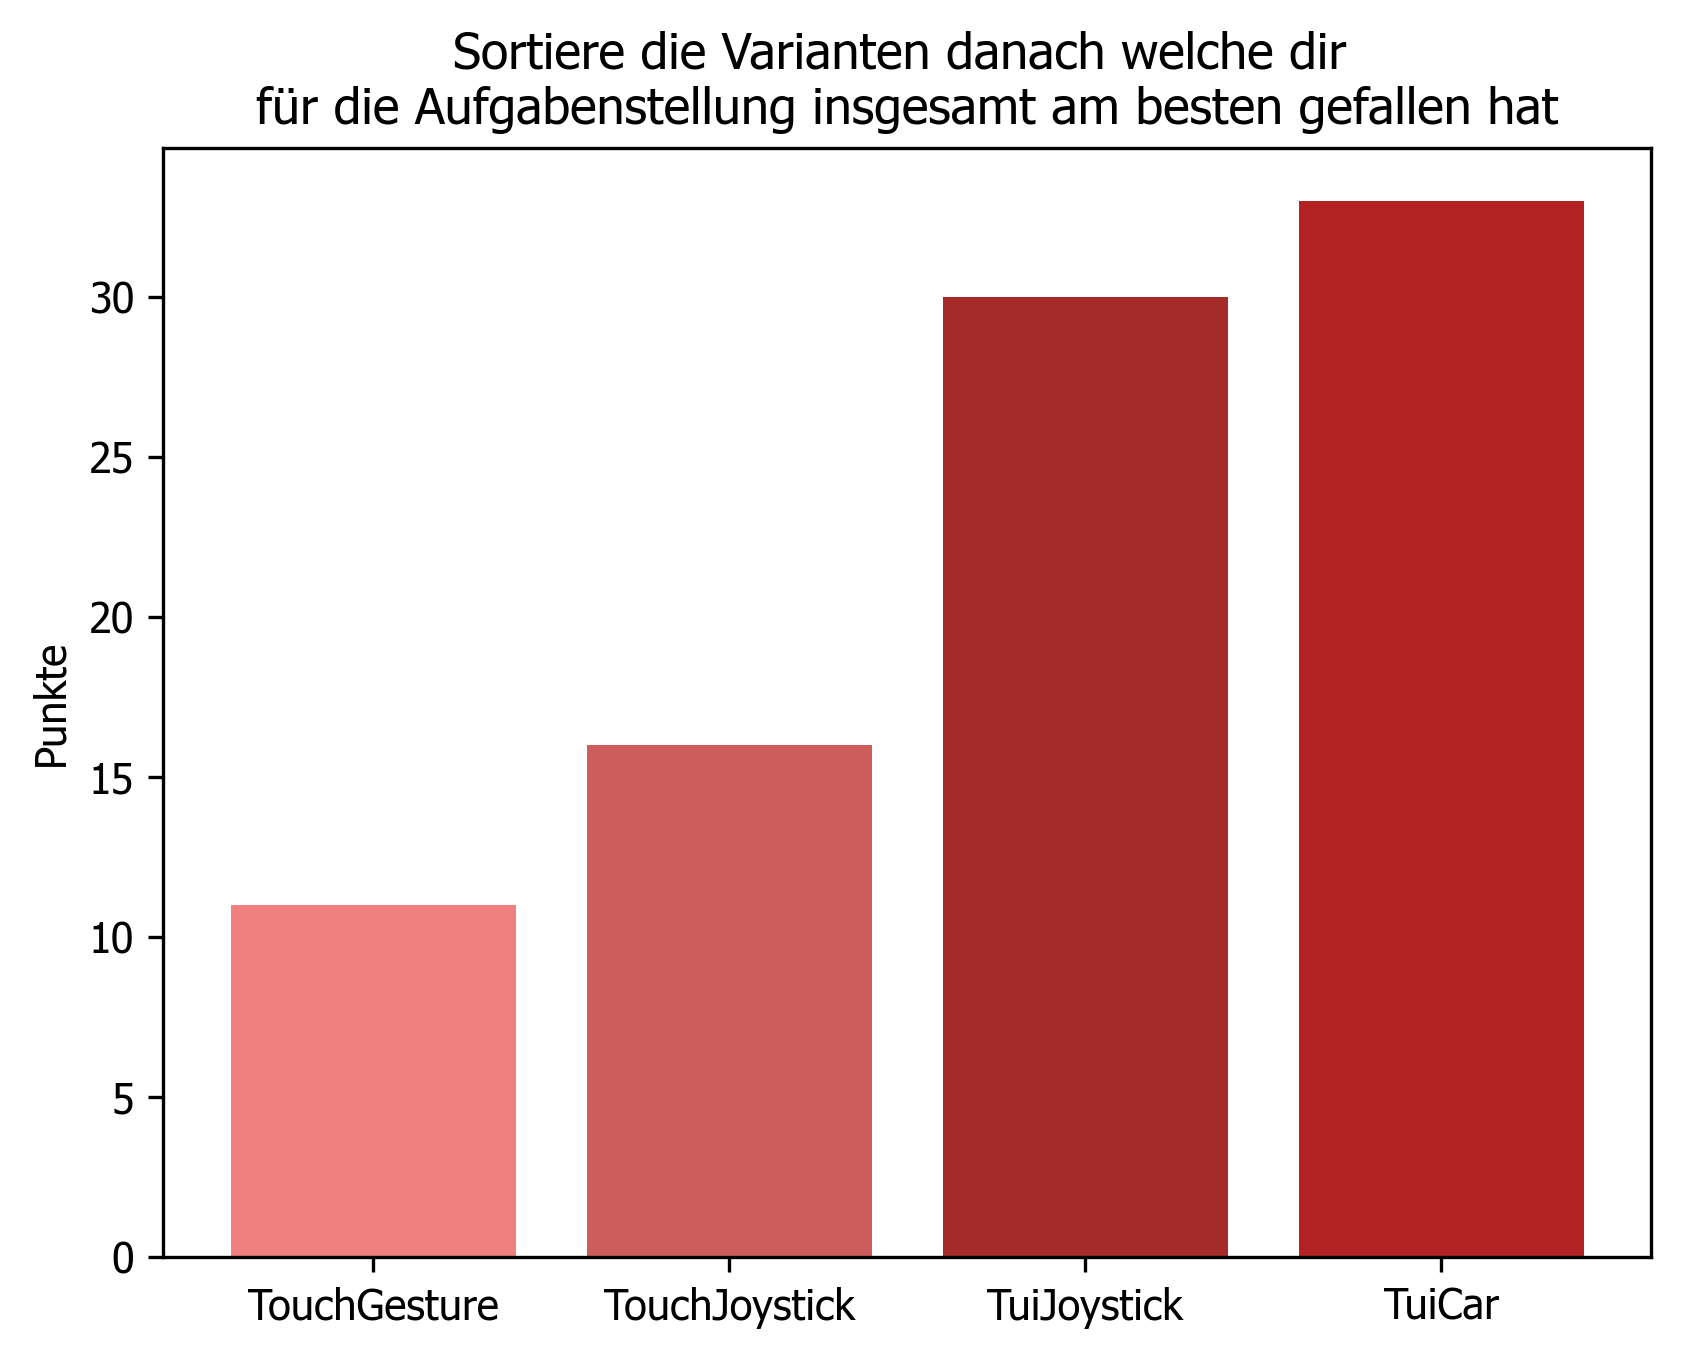

,Ranking
UserId,
1,"{1: InputCombination.TuiJoystick, 2: InputCombination.TuiCar, 3: InputCombination.TouchGesture, 4: InputCombination.TouchJoystick}"
2,"{1: InputCombination.TuiJoystick, 2: InputCombination.TuiCar, 3: InputCombination.TouchJoystick, 4: InputCombination.TouchGesture}"
3,"{1: InputCombination.TuiCar, 2: InputCombination.TouchGesture, 3: InputCombination.TuiJoystick, 4: InputCombination.TouchJoystick}"
4,"{1: InputCombination.TuiCar, 2: InputCombination.TuiJoystick, 3: InputCombination.TouchJoystick, 4: InputCombination.TouchGesture}"
5,"{1: InputCombination.TuiCar, 2: InputCombination.TouchJoystick, 3: InputCombination.TuiJoystick, 4: InputCombination.TouchGesture}"
6,"{1: InputCombination.TuiJoystick, 2: InputCombination.TuiCar, 3: InputCombination.TouchGesture, 4: InputCombination.TouchJoystick}"
7,"{1: InputCombination.TouchGesture, 2: InputCombination.TuiCar, 3: InputCombination.TuiJoystick, 4: InputCombination.TouchJoystick}"
8,"{1: InputCombination.TuiJoystick, 2: InputCombination.TouchJoystick, 3: InputCombination.TuiCar, 4: InputCombination.TouchGesture}"
9,"{1: InputCombination.TuiCar, 2: InputCombination.TouchJoystick, 3: InputCombination.TuiJoystick, 4: InputCombination.TouchGesture}"


In [248]:
plotter.plot_ranking()